In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\scanimage\AppData\Local\Temp\ipykernel_9056\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from matplotlib import pyplot as plt
import sys
import matplotlib.animation as animation
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import imageio

#import tables
#import deepdish as dd

#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append(r'C:\Users\scanimage\Documents\JJM\post_cnmfe_analysis')
import python_utils_jjm as utils_jjm

In [3]:
results_file = r'F:\MKB\13-Jun_11_52_21_out.mat'

In [4]:
results_file.split('/')[-1]

'F:\\MKB\\13-Jun_11_52_21_out.mat'

In [5]:
results_file[0:-4]+'_demixed_color.h5'

'F:\\MKB\\13-Jun_11_52_21_out_demixed_color.h5'

In [6]:
results = sio.loadmat(results_file)

In [7]:
results

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jun 13 13:40:26 2022',
 '__version__': '1.0',
 '__globals__': [],
 'A': <360000x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 9465 stored elements in Compressed Sparse Column format>,
 'A_prev': array([], shape=(0, 0), dtype=uint8),
 'C': array([[2.93705213e-01, 2.51882919e-01, 2.16015931e-01, ...,
         5.61202929e-06, 5.51919958e-06, 5.42790539e-06],
        [1.54582047e-01, 1.38036903e-01, 1.23262611e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.17787420e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.10702457e-10, 1.05183723e-10, 9.99401083e-11],
        [1.38083456e+00, 1.51317792e+00, 1.95224315e+00, ...,
         1.10590269e-02, 1.07533240e-02, 0.00000000e+00],
        [8.82562384e-01, 7.72275150e-01, 6.75769688e-01, ...,
         1.00442

##A is spatial contours

In [8]:
#img_file = '/Users/johnmarshall/Documents/Analysis/MiniscopeMovies/GRIN011/H10_M19_S59msCam1.tif'
#img_from_file = plt.imread(img_file)    
#d1, d2 = np.shape(img_from_file)
#d1, d2 = 480, 752
#v4 image is 600x600 pixels
d1, d2 = 600, 600

In [9]:
dense_A = results['A'].todense()

In [10]:
frames = np.shape(results['C'])[1]

In [11]:
cells = np.shape(results['C'])[0]

In [13]:
np.shape(results['C'])

(6, 28071)

In [14]:
frames

28071

In [15]:
cells

6

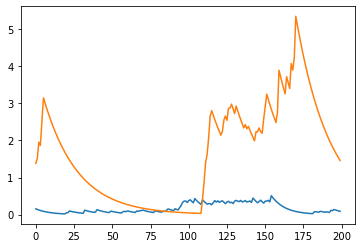

In [35]:
plt.plot(results['C'][1][:200])
plt.plot(results['C'][4][:200])

In [31]:
plt.show()

In [19]:
#reshape for all frames
frame_range = (100, 250)
cells_reshaped = np.empty((cells, frame_range[1]-frame_range[0], d1, d2))
for cell in tqdm(range(cells)):
    A_reshaped = np.reshape(dense_A[:, cell], (d1, d2))
    cells_reshaped[cell] = np.array([np.dot(A_reshaped, results['C'][cell, frame]) for frame in range(frame_range[0], frame_range[1])])
    


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.07it/s]


In [ ]:
#to add color use RBGA, where each pixel has 3 values for RBG and last for intensity
frame_range = (100, 150)
cells_reshaped_color = np.empty((cells, frame_range[1]-frame_range[0], d1, d2, 4))
for cell in tqdm(range(cells)):
    A_reshaped = np.reshape(dense_A[:, cell], (d1, d2))
    cell_frames = []
    for frame in range(frame_range[0], frame_range[1]):
        cell_frames.append(np.array([np.dot(A_reshaped, item) for item in [255, 128, 0, results['C'][cell, frame]]]))
    


In [23]:
np.shape(cells_reshaped)

(6, 150, 600, 600)

In [24]:
cells_recombined = np.sum(cells_reshaped, axis=0)

In [25]:
np.shape(cells_recombined)

(150, 600, 600)

In [26]:
np.shape(cells_recombined[1])

(600, 600)

In [27]:
hf = h5py.File(results_file[0:-4]+'_demixed_100_250.h5', 'w')

In [28]:
hf.create_dataset('demixed_movie_array', data=cells_recombined )

<HDF5 dataset "demixed_movie_array": shape (150, 600, 600), type "<f8">

In [29]:
hf.close()

In [ ]:
cells_recombined = np.sum(cells_reshaped, axis=0)

In [ ]:
imageio.mimwrite(results_file[0:-4]+'_demixed_.mp4', cells_recombined, fps = 20)

In [ ]:
## recombine demixed video with behavior data 
cnmfe_range = (0, 150)
dir_path = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/'
frame_clock_info = 'timestamp.dat'
frame_clock_df = pd.read_table(dir_path+frame_clock_info)

# load time stamps 
msCam_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0].set_index('frameNum')[cnmfe_range[0]:cnmfe_range[1]]
behavCam_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1].set_index('frameNum')
# reset initial clock value to 0 
msCam_timestamps['sysClock'][1] = 0
behavCam_timestamps['sysClock'][1] = 0

In [ ]:
# create df to find matched behavior cam frames
msCam_timestamps = jjm_utils.align_behavior_data(msCam_timestamps, behavCam_timestamps)
msCam_timestamps.reset_index(inplace=True)
msCam_timestamps.head()

In [ ]:
# 
reader = imageio.get_reader('/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/behavCam1.avi')

In [ ]:
bd1, bd2 = reader.get_meta_data()['size']

In [ ]:
1 in msCam_timestamps['behavCam_frames'].values

In [ ]:
behavior_adjusted = np.empty((cnmfe_range[1], bd2, bd1, 3))    
#for frame in range(cnmfe_range[0], cnmfe_range[1])
frame = 0
for i, im in enumerate(reader):
    if 1 in msCam_timestamps['behavCam_frames'].values:
        behavior_adjusted[0] = im
        

In [ ]:
# combine those matched frames into a video

imageio.mimwrite('/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/behavior_adjusted.mp4', behavior_adjusted, fps = 20)